In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [2]:
#np.random.seed(12321)

alpha = 10 # IBP parameter

num_samples = 50 # sample size
D = 2 # dimension

sigma_a = 3.0 ** 2

sigma_eps = 1.0 ** 2 # variance of noise

k_inf = 3 # take to be large for a good approximation to the IBP

pi, Z, mu, A, X = vi.generate_data(num_samples, D, k_inf, sigma_a, sigma_eps, alpha)

k_approx = k_inf # variational truncation

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, D, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = DataSet(X, k_approx, alpha, sigma_eps, sigma_a)

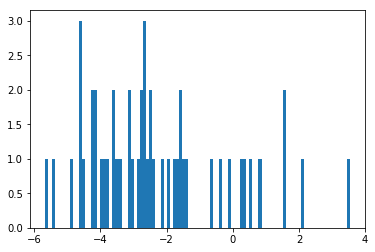

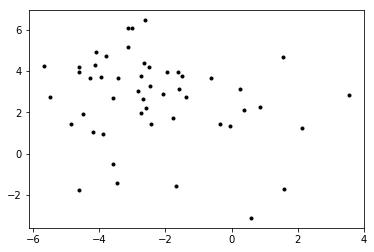

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
# Parameters approximating the true distribution

tau_true = np.zeros_like(tau_init)
tau_true_scale = 15.
tau_true[:, 0] = deepcopy(Pi) * tau_true_scale
tau_true[:, 1] = tau_true_scale

nu_true = np.zeros_like(nu_init)
nu_true[Z == 1] = 0.999
nu_true[Z == 0] = 0.001

phi_mu_true = np.zeros_like(phi_mu_init)
phi_mu_true[:] = A.transpose()
phi_var_true = np.zeros_like(phi_var_init)
phi_var_true[:] = 0.01

params_true = packing.pack_params(deepcopy(tau_true), deepcopy(phi_mu_true),
                                  deepcopy(phi_var_true), deepcopy(nu_true))

In [5]:
import time
par_hp_hess_time = time.time()
par_hp_hess = data_set.get_kl_sens_hess(params_init, hyper_params)
par_hp_hess_time = time.time() - par_hp_hess_time
print('Num samples: %d' % Num_samples)
print('Hessian time:')
print(par_hp_hess_time)

Num samples: 50
Hessian time:
0.0110011100769


In [6]:
true_init = False
if true_init:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_true)
else:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_init)

tau, nu, phi_mu, phi_var = data_set.run_cavi(tau, nu, phi_mu, phi_var, max_iter=100, tol=1e-6)

cavi_tau = deepcopy(tau)
cavi_phi_mu = deepcopy(phi_mu)
cavi_phi_var = deepcopy(phi_var)
cavi_nu = deepcopy(nu)

Step 0 KL: 45.319347803
Step 10 KL: 1.03684052619
Step 20 KL: 1.12708921454
Step 30 KL: 0.563728132719
Step 40 KL: 0.0574976414352
Step 50 KL: 0.00695506954154
Step 60 KL: 0.000831872221838
Step 70 KL: 9.94627094499e-05
Step 80 KL: 1.18732011032e-05
Step 90 KL: 1.41501823947e-06
Done with CAVI.


In [7]:
nu_tol = 1e-8
cavi_nu_trim = deepcopy(cavi_nu)
cavi_nu_trim[cavi_nu_trim < nu_tol] = nu_tol
cavi_nu_trim[cavi_nu_trim > 1 - nu_tol] = 1 - nu_tol

cavi_params = packing.pack_params(cavi_tau, cavi_phi_mu, cavi_phi_var, cavi_nu_trim)
print np.all(np.isfinite(cavi_params))

True


In [8]:
data_set.trace.reset()
vb_opt = data_set.run_newton_tr(cavi_params, maxiter=50, gtol=1e-2)

Step 0 KL: -390.555060174
Optimization terminated successfully.
         Current function value: -390.563269
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 0
Done with Newton trust region.


In [9]:
print 'CAVI:'
print cavi_phi_mu.transpose()

print 'Full TR:'
tau, phi_mu, phi_var, nu = data_set.unpack_params(vb_opt.x)
print phi_mu.transpose()

print 'Truth:'
print A



CAVI:
[[-3.87479161  1.62498513]
 [ 0.86095145  2.27324601]
 [-0.67239648 -4.96465667]]
Full TR:
[[-3.87747125  1.62087546]
 [ 0.86319319  2.27376982]
 [-0.67322665 -4.96391827]]
Truth:
[[ 0.28145505  4.00563621]
 [ 0.06830239 -1.07415619]
 [-3.80462057  0.4087602 ]]


Cavi residuals: 78.1520045811    Trust residuals: 78.2574361263


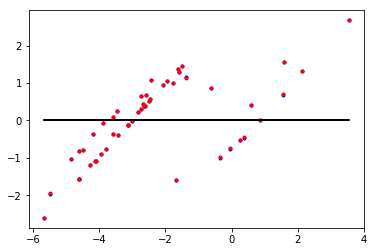

In [10]:
cavi_resid = data_set.x - data_set.get_prediction(cavi_params)
tr_resid = data_set.x - data_set.get_prediction(vb_opt.x)

plt.figure()
col = 0
plt.plot(data_set.x[:, col], tr_resid[:, col], '.b')
plt.plot(data_set.x[:, col], cavi_resid[:, col], '.r')
plt.plot(data_set.x[:, col], np.full_like(data_set.x[:, col], 0.), 'k')

print('Cavi residuals: {}    Trust residuals: {}'.format(
       np.sum(np.abs(cavi_resid)), np.sum(np.abs(tr_resid))))
